In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import yeojohnson, boxcox

In [2]:
restaurants_df = pd.read_csv("../Foursquare/final_restaurants_dataset_cleaned.csv")
coffeeshops_df = pd.read_csv("../Foursquare/final_coffeeshops_dataset_cleaned.csv")
print(restaurants_df.info())
print(coffeeshops_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Business ID                               1221 non-null   object 
 1   Name                                      1221 non-null   object 
 2   Latitude                                  1221 non-null   float64
 3   Longitude                                 1221 non-null   float64
 4   Category                                  1221 non-null   object 
 5   Rating                                    1221 non-null   object 
 6   Popularity                                1221 non-null   float64
 7   Google Place ID                           1221 non-null   object 
 8   Business Status                           1221 non-null   object 
 9   Distance (m)                              1221 non-null   float64
 10  Cluster                             

In [3]:
combined_df = pd.concat([coffeeshops_df, restaurants_df], ignore_index=True)
combined_df["generalCategory"] = combined_df["generalCategory"].map({"coffee shop": 0, "restaurant": 1})

In [4]:
import pandas as pd


# Display basic info about the dataset
print("Initial Dataset Info:")
print(combined_df.info())
print("\nSummary Statistics:")
print(combined_df.describe())

# Check for missing values
print("\nMissing Values:")
print(combined_df.isnull().sum())

# Handle missing values
# Fill numerical columns with median values
num_cols = combined_df.select_dtypes(include=['number']).columns
combined_df[num_cols] = combined_df[num_cols].fillna(combined_df[num_cols].median())

# Fill categorical columns with mode (most frequent value)
cat_cols = combined_df.select_dtypes(include=['object']).columns
combined_df[cat_cols] = combined_df[cat_cols].fillna(combined_df[cat_cols].mode().iloc[0])

# Remove duplicate rows if any
combined_df.drop_duplicates(inplace=True)

# Remove outliers using IQR method
Q1 = combined_df[num_cols].quantile(0.25)
Q3 = combined_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
combined_df = combined_df[~((combined_df[num_cols] < (Q1 - 1.5 * IQR)) | (combined_df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Display final info after fixing issues
print("\nFinal Dataset Info:")
print(combined_df.info())



Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Business ID                               1910 non-null   object 
 1   Name                                      1910 non-null   object 
 2   Latitude                                  1910 non-null   float64
 3   Longitude                                 1910 non-null   float64
 4   Category                                  1910 non-null   object 
 5   Rating                                    1910 non-null   object 
 6   Popularity                                1910 non-null   float64
 7   Google Place ID                           1909 non-null   object 
 8   Business Status                           1910 non-null   object 
 9   Distance (m)                              1910 non-null   float64
 10  Cluster       

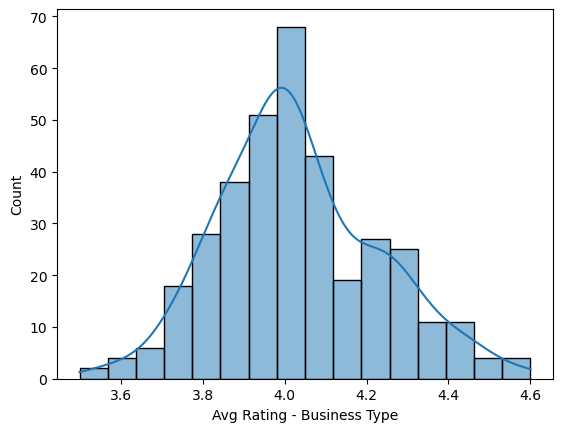

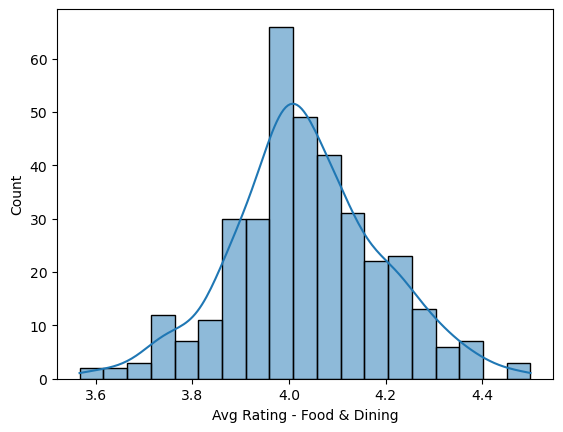

In [5]:
sns.histplot(combined_df["Avg Rating - Business Type"], kde=True)
plt.show()
sns.histplot(combined_df["Avg Rating - Food & Dining"], kde=True)
plt.show()


In [6]:
irrelevant_columns = ['Business ID', 'Name', 'Latitude', 'Longitude', 'Category', 'Rating', 
                      'Google Place ID', 'Business Status', 'Distance (m)', 'Cluster']
combined_df.drop(columns=irrelevant_columns, inplace=True)

In [7]:
competition_cols = [
    "Competition - Business Type/Area",
    "Competition - Food & Dining/Area",
    "Competition - Business Type/POI Density",
    "Competition - Food & Dining/POI Density",
    "Competition - Business Type/related POIs",
    "Competition - Food & Dining/related POIs"
]

avg_rating_cols = ["Avg Rating - Business Type", "Avg Rating - Food & Dining"]

target_col = "Popularity"

In [8]:
print(combined_df.isnull().sum())  # Check for NaNs
#df = df.dropna()  # Drop any missing values


Popularity                                  0
generalCategory                             0
Religious Institutions                      0
Coffee Shops                                0
Food & Dining                               0
Restaurants                                 0
Home & Construction Services                0
Entertainment & Recreation                  0
Retail & Shopping                           0
Finance & Services                          0
Education                                   0
Health                                      0
Public & Government Services                0
Hotels & Hospitality                        0
Transportation & Travel                     0
Beauty & Wellness                           0
POI Density                                 0
Avg Rating - Business Type                  0
Avg Rating - Food & Dining                  0
Competition - Business Type/Area            0
Competition - Food & Dining/Area            0
Competition - Business Type/POI De

In [9]:
# Helper Functions to remove outliers and highly correlated features

def remove_outliers(X, y):
    """Remove outliers using IQR."""
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    return X[mask], y[mask]

    
# Remove Highly Correlated Features (Modified)
removed_corr_features = []  # List to store removed features

def remove_highly_correlated_features(X, threshold=0.95):
    """Removes highly correlated features from X."""
    corr_matrix = X.corr().abs()  # Compute absolute correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Upper triangle

    # Find columns to drop
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    return X.drop(columns=to_drop, errors='ignore'), to_drop  # Drop and return removed features

In [18]:
!pip uninstall protobuf -y
!pip install protobuf==3.20.*
!pip install --upgrade tensorflow

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
   ---------------------------------------- 0.0/162.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/162.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/162.1 kB ? eta -:--:--
   -- ------------------------------------- 10.2/162.1 kB ? eta -:--:--
   -- ------------------------------------- 10.2/162.1 kB ? eta -:--:--
   -- ------------------------------------- 10.2/162.1 kB ? eta -:--:--
   ------- ------------------------------- 30.7/162.1 kB 146.3 kB/s eta 0:00:01
   --------- ----------------------------- 41.0/162.1 kB 151.3 kB/s eta 0:00:01
   -------------- ------------------------ 61.4/162.1 kB 204.8 kB/s eta 0:00:01
   ----------------- --------------------- 71.7/162.1 kB 218.6 kB/s eta 0:00:01
   ---------------------------- --------- 122.9/162.1 kB 327.4 kB/s eta 0:00:01
   -------------------------------------- 162.1/162.1

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Function to remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.95):
    """Remove features that are highly correlated with each other."""
    X_df = pd.DataFrame(X)
    corr_matrix = X_df.corr().abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return X_df.drop(columns=to_drop, errors='ignore')

# Assuming combined_df is your DataFrame
transformed_df = restaurants_df.copy()

# Remove outliers in 'Popularity'
Q1 = transformed_df['Popularity'].quantile(0.25)
Q3 = transformed_df['Popularity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
transformed_df = transformed_df[(transformed_df['Popularity'] >= lower_bound) & (transformed_df['Popularity'] <= upper_bound)]

# Select numerical columns
num_cols = transformed_df.select_dtypes(include=['number']).columns

# Apply PowerTransformer (normalize distribution)
power_transformer = PowerTransformer()
transformed_df[num_cols] = power_transformer.fit_transform(transformed_df[num_cols])

# Apply MinMaxScaler (scale to 0-1)
minmax_scaler = MinMaxScaler()
transformed_df[num_cols] = minmax_scaler.fit_transform(transformed_df[num_cols])

# Feature Selection
feature_cols = [
    "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
    "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
    "Finance & Services", "Education", "Health", "Public & Government Services",
    "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
    "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
    "Population Within 1km"
]

# Ensure selected features exist in dataset
X = transformed_df[feature_cols].copy()
y = transformed_df['Popularity']

# Apply the correlation-based feature removal function
X = remove_highly_correlated_features(X, threshold=0.90)

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Reshape input data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)  # Reshape to (samples, timesteps=1, features)
X_test = np.expand_dims(X_test, axis=1)

# Build LSTM model
# Build LSTM model with updated parameters
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    LSTM(16, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output
])

# Compile model with updated learning rate
model.compile(optimizer=Adam(learning_rate=0.0010), loss='mse', metrics=['mae'])

# Train model with updated epochs
history = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), verbose=1)

print("LSTM model trained successfully!")

# Predictions
y_pred = model.predict(X_test)

# Compute Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
max_err = max_error(y_test, y_pred)
mad = np.mean(np.abs(y_test - np.mean(y_test)))  # Mean Absolute Deviation

# Print Results in Table Format
print(f"{'Metric':<15} │ {'Value':>10}")
print("-" * 35)
print(f"{'RMSE':<15} │ {rmse:>10.4f}")
print(f"{'MSE':<15} │ {mse:>10.4f}")
print(f"{'MAE':<15} │ {mae:>10.4f}")
print(f"{'R²':<15} │ {r2:>10.4f}")
print(f"{'MedAE':<15} │ {medae:>10.4f}")
print(f"{'Max Error':<15} │ {max_err:>10.4f}")
print(f"{'MAD':<15} │ {mad:>10.4f}")


X_train shape: (200, 17), X_test shape: (51, 17)
y_train shape: (200,), y_test shape: (51,)


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.3623 - mae: 0.5349 - val_loss: 0.2615 - val_mae: 0.4349
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2857 - mae: 0.4715 - val_loss: 0.1397 - val_mae: 0.2990
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1390 - mae: 0.3138 - val_loss: 0.0801 - val_mae: 0.2483
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1109 - mae: 0.2820 - val_loss: 0.0803 - val_mae: 0.2492
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1070 - mae: 0.2756 - val_loss: 0.0770 - val_mae: 0.2420
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0837 - mae: 0.2487 - val_loss: 0.0761 - val_mae: 0.2410
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1046 - mae: 0.2762 - val_loss: 0.0755 - val_mae: 0.2399
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0862 - mae: 0.2514 - val_loss: 0.0751 - val_mae: 0.2393
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0918 - mae:

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=25):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to train LSTM with fixed parameters
def train_lstm(df):
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]

    X = df[feature_cols].copy()
    y = df["Popularity"].copy()

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

    # Define sequence length (fixed)
    sequence_length = 25

    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, sequence_length)

    # Reshape input to match LSTM expectations
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Build LSTM Model with fixed parameters
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(sequence_length, X_train.shape[1])),
        Dropout(0.2),
        LSTM(16, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0010), loss='mse', metrics=['mae'])

    # Training with early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_seq, y_train_seq, epochs=25, batch_size=16, validation_data=(X_test_seq, y_test_seq),
                        verbose=1, callbacks=[early_stop])

    print("LSTM model trained successfully!")

    # Predictions
    y_pred = model.predict(X_test_seq)

    # Compute Metrics
    mae = mean_absolute_error(y_test_seq, y_pred)
    mse = mean_squared_error(y_test_seq, y_pred)
    r2 = r2_score(y_test_seq, y_pred)
    rmse = np.sqrt(mse)
    medae = median_absolute_error(y_test_seq, y_pred)
    max_err = max_error(y_test_seq, y_pred)
    mad = np.mean(np.abs(y_test_seq - np.mean(y_test_seq)))  # Mean Absolute Deviation

    # Print Results in Table Format
    print(f"{'Metric':<15} │ {'Value':>10}")
    print("-" * 35)
    print(f"{'RMSE':<15} │ {rmse:>10.4f}")
    print(f"{'MSE':<15} │ {mse:>10.4f}")
    print(f"{'MAE':<15} │ {mae:>10.4f}")
    print(f"{'R²':<15} │ {r2:>10.4f}")
    print(f"{'MedAE':<15} │ {medae:>10.4f}")
    print(f"{'Max Error':<15} │ {max_err:>10.4f}")
    print(f"{'MAD':<15} │ {mad:>10.4f}")

    return model, history

In [10]:
lstm_model = train_lstm(restaurants_df)

Epoch 1/25


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.8735 - mae: 0.9297 - val_loss: 0.2517 - val_mae: 0.5010
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2632 - mae: 0.4751 - val_loss: 0.0018 - val_mae: 0.0376
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0369 - mae: 0.1541 - val_loss: 0.0211 - val_mae: 0.1426
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0372 - mae: 0.1580 - val_loss: 7.3912e-04 - val_mae: 0.0234
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0342 - mae: 0.1467 - val_loss: 9.7350e-04 - val_mae: 0.0223
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0251 - mae: 0.1197 - val_loss: 8.7262e-04 - val_mae: 0.0218
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0358 - mae: 0.1547 - val_loss: 0.0014 - val_mae: 0.0314
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0233 - mae: 0.1214 - val_loss: 0.0027 - val_mae: 0.0447
Epoch 9/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0287 - mae: 0.1403 

# 14

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=25):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to train LSTM with fixed best parameters
def train_lstm(df):
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]

    X = df[feature_cols].copy()
    y = df["Popularity"].copy()

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

    # Fixed sequence length
    sequence_length = 25

    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, sequence_length)

    # Reshape input to match LSTM expectations
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Build LSTM Model with fixed best parameters
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
        Dropout(0.3),
        Bidirectional(LSTM(16, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0010), loss='mse', metrics=['mae'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    # Train the model with fixed parameters
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq),
                        verbose=1, callbacks=[early_stop, lr_scheduler])

    print("LSTM model trained successfully!")

    # Predictions
    y_pred = model.predict(X_test_seq)

    # Compute Metrics
    mae = mean_absolute_error(y_test_seq, y_pred)
    mse = mean_squared_error(y_test_seq, y_pred)
    r2 = r2_score(y_test_seq, y_pred)
    rmse = np.sqrt(mse)
    medae = median_absolute_error(y_test_seq, y_pred)
    max_err = max_error(y_test_seq, y_pred)
    mad = np.mean(np.abs(y_test_seq - np.mean(y_test_seq)))  # Mean Absolute Deviation

    # Print Results in Table Format
    print(f"{'Metric':<15} │ {'Value':>10}")
    print("-" * 35)
    print(f"{'RMSE':<15} │ {rmse:>10.4f}")
    print(f"{'MSE':<15} │ {mse:>10.4f}")
    print(f"{'MAE':<15} │ {mae:>10.4f}")
    print(f"{'R²':<15} │ {r2:>10.4f}")
    print(f"{'MedAE':<15} │ {medae:>10.4f}")
    print(f"{'Max Error':<15} │ {max_err:>10.4f}")
    print(f"{'MAD':<15} │ {mad:>10.4f}")

    return model, history


In [13]:
model = train_lstm(restaurants_df)

Epoch 1/50


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 0.3952 - mae: 0.5477 - val_loss: 0.0249 - val_mae: 0.1559 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0592 - mae: 0.2053 - val_loss: 0.0072 - val_mae: 0.0812 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0296 - mae: 0.1406 - val_loss: 0.0065 - val_mae: 0.0765 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0280 - mae: 0.1302 - val_loss: 6.3855e-04 - val_mae: 0.0236 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0225 - mae: 0.1217 - val_loss: 7.3643e-04 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0219 - mae: 0.1165 - val_loss: 0.0083 - val_mae: 0.0876 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0172 - mae: 0.1091 - val_loss: 0.0024 - val_mae: 0.0424 - learning_rate: 0.0010
Epoch 8/50
8/8 ━━━━━━━━━━━━━

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, median_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=20):  # Reduced sequence length
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to train optimized LSTM model
def train_lstm(df):
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]

    X = df[feature_cols].copy()
    y = df["Popularity"].copy()

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)

    # Normalize features using StandardScaler
    feature_scaler = MaxAbsScaler()
    X_scaled = feature_scaler.fit_transform(X)

    # Normalize the target variable
    target_scaler = MaxAbsScaler()
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Adjusted sequence length
    sequence_length = 25  # Reduced from 25 to minimize noise

    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

    # Reshape input to match LSTM expectations
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Build LSTM Model with fixed best parameters
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
        Dropout(0.3),
        Bidirectional(LSTM(16, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0010), loss='mse', metrics=['mae'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    # Train the model with fixed parameters
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq),
                        verbose=1, callbacks=[early_stop, lr_scheduler])

    print("LSTM model trained successfully!")

    # Predictions (inverse transform back to original scale)
    y_pred_scaled = model.predict(X_test_seq)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)  # Convert predictions back to original scale
    y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))  # Convert actual values back

    # Compute Metrics
    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred)
    medae = median_absolute_error(y_test_actual, y_pred)
    max_err = max_error(y_test_actual, y_pred)
    mad = np.mean(np.abs(y_test_actual - np.mean(y_test_actual)))  # Mean Absolute Deviation

    # Print Results in Table Format
    print(f"\n{'Metric':<15} │ {'Value':>10}")
    print("-" * 35)
    print(f"{'RMSE':<15} │ {rmse:>10.4f}")
    print(f"{'MSE':<15} │ {mse:>10.4f}")
    print(f"{'MAE':<15} │ {mae:>10.4f}")
    print(f"{'R²':<15} │ {r2:>10.4f}")
    print(f"{'MedAE':<15} │ {medae:>10.4f}")
    print(f"{'Max Error':<15} │ {max_err:>10.4f}")
    print(f"{'MAD':<15} │ {mad:>10.4f}")

    return model, history


In [10]:
model = train_lstm(restaurants_df)

Epoch 1/50


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - loss: 0.7459 - mae: 0.8264 - val_loss: 0.0075 - val_mae: 0.0819 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0698 - mae: 0.2219 - val_loss: 0.0019 - val_mae: 0.0378 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0444 - mae: 0.1709 - val_loss: 0.0010 - val_mae: 0.0278 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0228 - mae: 0.1210 - val_loss: 0.0011 - val_mae: 0.0236 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0329 - mae: 0.1415 - val_loss: 0.0015 - val_mae: 0.0323 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0233 - mae: 0.1165 - val_loss: 0.0013 - val_mae: 0.0302 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0310 - mae: 0.1412 - val_loss: 8.3635e-04 - val_mae: 0.0259 - learning_rate: 0.0010
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, median_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=20):  # Reduced sequence length
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to train optimized LSTM model
def train_lstm(df):
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]

    X = df[feature_cols].copy()
    y = df["Popularity"].copy()

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)

    # Normalize features using StandardScaler
    feature_scaler = MaxAbsScaler()
    X_scaled = feature_scaler.fit_transform(X)

    # Normalize the target variable
    target_scaler = MaxAbsScaler()
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Adjusted sequence length
    sequence_length = 20  # Reduced from 25 to minimize noise

    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

    # Reshape input to match LSTM expectations
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Build Optimized LSTM Model
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),  # Reduced neurons
        Dropout(0.2),
        LSTM(32, return_sequences=False),  # Reduced second LSTM layer
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Predicting the scaled target variable
    ])

    # Compile model with optimized learning rate
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])  # Reduced LR to 0.0005

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    # Train the model with optimized parameters
    history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq),
                        verbose=1, callbacks=[early_stop, lr_scheduler])  # Reduced batch size to 32

    print("\n✅ LSTM Model Training Completed!")

    # Predictions (inverse transform back to original scale)
    y_pred_scaled = model.predict(X_test_seq)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)  # Convert predictions back to original scale
    y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))  # Convert actual values back

    # Compute Metrics
    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred)
    medae = median_absolute_error(y_test_actual, y_pred)
    max_err = max_error(y_test_actual, y_pred)
    mad = np.mean(np.abs(y_test_actual - np.mean(y_test_actual)))  # Mean Absolute Deviation

    # Print Results in Table Format
    print(f"\n{'Metric':<15} │ {'Value':>10}")
    print("-" * 35)
    print(f"{'RMSE':<15} │ {rmse:>10.4f}")
    print(f"{'MSE':<15} │ {mse:>10.4f}")
    print(f"{'MAE':<15} │ {mae:>10.4f}")
    print(f"{'R²':<15} │ {r2:>10.4f}")
    print(f"{'MedAE':<15} │ {medae:>10.4f}")
    print(f"{'Max Error':<15} │ {max_err:>10.4f}")
    print(f"{'MAD':<15} │ {mad:>10.4f}")

    return model, history


In [38]:
model = train_lstm(restaurants_df)

c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 483ms/step - loss: 0.8243 - mae: 0.9062 - val_loss: 0.5850 - val_mae: 0.7645 - learning_rate: 5.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.5429 - mae: 0.7323 - val_loss: 0.2727 - val_mae: 0.5217 - learning_rate: 5.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2476 - mae: 0.4852 - val_loss: 0.0363 - val_mae: 0.1891 - learning_rate: 5.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0722 - mae: 0.2320 - val_loss: 0.0281 - val_mae: 0.1662 - learning_rate: 5.0000e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0568 - mae: 0.2013 - val_loss: 0.0863 - val_mae: 0.2929 - learning_rate: 5.0000e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0603 - mae: 0.2149 - val_loss: 0.0328 - val_mae: 0.1796 - learning_rate: 5.0000e-04
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0352 - mae: 0.1592 - val_loss: 0.0013 - val_mae: 0.0289 - learning_rate: 5

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=20):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to train LSTM model
def train_lstm(df):
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]

    X = df[feature_cols].copy()
    y = df["Popularity"].copy()

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)

    # Normalize features using StandardScaler
    feature_scaler = MaxAbsScaler()
    X_scaled = feature_scaler.fit_transform(X)

    # Normalize the target variable
    target_scaler = MaxAbsScaler()
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=SEED, shuffle=False)

    # Sequence length
    sequence_length = 20

    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

    # Reshape input to match LSTM expectations
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Build Optimized LSTM Model
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Compile model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    # Train the model
    history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq),
                        verbose=1, callbacks=[early_stop, lr_scheduler])

    print("\n✅ LSTM Model Training Completed!")

    # Predictions (inverse transform back to original scale)
    y_pred_scaled = model.predict(X_test_seq)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

    # Compute Metrics
    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred)
    medae = median_absolute_error(y_test_actual, y_pred)
    max_err = max_error(y_test_actual, y_pred)
    mad = np.mean(np.abs(y_test_actual - np.mean(y_test_actual)))

    # Print Results in Table Format
    print(f"\n{'Metric':<15} │ {'Value':>10}")
    print("-" * 35)
    print(f"{'RMSE':<15} │ {rmse:>10.4f}")
    print(f"{'MSE':<15} │ {mse:>10.4f}")
    print(f"{'MAE':<15} │ {mae:>10.4f}")
    print(f"{'R²':<15} │ {r2:>10.4f}")
    print(f"{'MedAE':<15} │ {medae:>10.4f}")
    print(f"{'Max Error':<15} │ {max_err:>10.4f}")
    print(f"{'MAD':<15} │ {mad:>10.4f}")

    return model, history


In [11]:
model = train_lstm(restaurants_df)

Epoch 1/100


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 488ms/step - loss: 0.8775 - mae: 0.9352 - val_loss: 0.6526 - val_mae: 0.8075 - learning_rate: 5.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6331 - mae: 0.7933 - val_loss: 0.3791 - val_mae: 0.6152 - learning_rate: 5.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3531 - mae: 0.5875 - val_loss: 0.1336 - val_mae: 0.3647 - learning_rate: 5.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1295 - mae: 0.3394 - val_loss: 0.0038 - val_mae: 0.0570 - learning_rate: 5.0000e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0282 - mae: 0.1378 - val_loss: 0.0380 - val_mae: 0.1937 - learning_rate: 5.0000e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0525 - mae: 0.1916 - val_loss: 0.0613 - val_mae: 0.2466 - learning_rate: 5.0000e-04
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0630 - mae: 0.2197 - val_loss: 0.0211 - val_mae: 0.1438 - learning_rate: 5.0000e-04
Ep

# Grid search

# LSTM - EXP 1

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=20):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# Grid search function
def grid_search_lstm(df):
    X = df.drop(columns=['Popularity', 'Avg Rating - Business Type', 'Competition - Business Type/Area', 
                         'Competition - Food & Dining/Area', 'Competition - Business Type/POI Density', 
                         'Competition - Food & Dining/POI Density', 'Competition - Business Type/related POIs'])
    y = df["Popularity"]

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)
    X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.9)
    print(f"Removed highly correlated features: {removed_corr_features}")
    
    # Split dataset (80% train, 20% test) BEFORE applying transformations
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply PowerTransformer (normalize distribution) on training set only
    num_cols = X.select_dtypes(include=['number']).columns
    power_transformer = PowerTransformer()
    
    X_train[num_cols] = power_transformer.fit_transform(X_train[num_cols])
    X_test[num_cols] = power_transformer.transform(X_test[num_cols])  # Apply same transformation

    # Normalize features using MinMaxScaler (on numerical columns only)
    feature_scaler = MinMaxScaler()
    X_train[num_cols] = feature_scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = feature_scaler.transform(X_test[num_cols])

    # Normalize the target variable separately
    target_scaler = MinMaxScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

    # Sequence length
    sequence_length = 20

    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train.values, y_train_scaled, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test.values, y_test_scaled, sequence_length)

    # Reshape input to match LSTM expectations
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Define hyperparameters for grid search
    lstm_units = [32, 64, 128]
    dropout_rates = [0.2, 0.3, 0.4]
    learning_rates = [0.001, 0.0005, 0.0001]
    batch_sizes = [16, 32, 64]

    best_model = None
    best_loss = float('inf')
    best_params = {}

    # Perform grid search
    for units, dropout, lr, batch_size in product(lstm_units, dropout_rates, learning_rates, batch_sizes):
        print(f"Training model with LSTM Units: {units}, Dropout: {dropout}, LR: {lr}, Batch Size: {batch_size}")
        
        # Build LSTM model
        model = Sequential([
            Bidirectional(LSTM(units, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
            Dropout(dropout),
            LSTM(units // 2, return_sequences=False),
            Dropout(dropout),
            Dense(units, activation='relu'),
            Dense(units // 2, activation='relu'),
            Dense(1)
        ])

        # Compile model
        model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        # Train model
        history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq),
                            verbose=0, callbacks=[early_stop, lr_scheduler])

        # Get best validation loss
        val_loss = min(history.history['val_loss'])
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = {'LSTM Units': units, 'Dropout': dropout, 'Learning Rate': lr, 'Batch Size': batch_size}

    print("\n✅ Best Model Found!")
    print(best_params)

    # Make predictions with the best model
    y_pred = best_model.predict(X_test_seq)

    # Rescale predictions and actual values back to original scale
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test_actual, y_pred_original)
    mse = mean_squared_error(y_test_actual, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred_original)

    print("\n📊 Best Model Metrics:")
    print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    return best_model, best_params


In [11]:
model, best_params = grid_search_lstm(combined_df)

Removed highly correlated features: ['Restaurants']
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 16


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 32

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 64

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 16

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 32

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 64

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.000250000011874362

In [11]:
model, best_params = grid_search_lstm(combined_df)

Removed highly correlated features: ['Restaurants']
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 16


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 32

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 64

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 16

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 32

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 64

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00025000001187436

In [ ]:
model, best_params = grid_search_lstm(combined_df)

Removed highly correlated features: ['Restaurants']
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 16


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 32

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 64

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 16

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 32

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 64

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.000250000011874

NO POWERTRANSFORM

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=20):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# Grid search function
def grid_search_lstm(df):
    X = df.drop(columns=['Popularity', 'generalCategory', 'Avg Rating - Business Type', 
                         'Competition - Business Type/Area', 'Competition - Food & Dining/Area',
                         'Competition - Business Type/POI Density', 'Competition - Food & Dining/POI Density',
                         'Competition - Business Type/related POIs'])
    y = df["Popularity"]

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)
    X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.9)
    print(f"Removed highly correlated features: {removed_corr_features}")
    
    # Apply PowerTransformer (normalize distribution) only on training data
    num_cols = X.select_dtypes(include=['number']).columns
    power_transformer = PowerTransformer()
    
    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize features using MinMaxScaler (excluding specified columns)
    ex_cols = ['Competition - Food & Dining/related POIs', 'Avg Rating - Food & Dining']
    feature_scaler = MinMaxScaler()
    
    cols_to_scale = [col for col in X_train.columns if col not in ex_cols]
    X_train[cols_to_scale] = feature_scaler.fit_transform(X_train[cols_to_scale])
    X_test[cols_to_scale] = feature_scaler.transform(X_test[cols_to_scale])  # Transform test set separately

    # Sequence length
    sequence_length = 20

    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, sequence_length)

    # Reshape input to match LSTM expectations
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Define hyperparameters for grid search
    lstm_units = [32, 64, 128]
    dropout_rates = [0.2, 0.3, 0.4]
    learning_rates = [0.001, 0.0005, 0.0001]
    batch_sizes = [16, 32, 64]

    best_model = None
    best_loss = float('inf')
    best_params = {}

    # Perform grid search
    for units, dropout, lr, batch_size in product(lstm_units, dropout_rates, learning_rates, batch_sizes):
        print(f"Training model with LSTM Units: {units}, Dropout: {dropout}, LR: {lr}, Batch Size: {batch_size}")
        
        # Build LSTM model
        model = Sequential([
            Bidirectional(LSTM(units, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
            Dropout(dropout),
            LSTM(units // 2, return_sequences=False),
            Dropout(dropout),
            Dense(units, activation='relu'),
            Dense(units // 2, activation='relu'),
            Dense(1)
        ])

        # Compile model
        model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        # Train model
        history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq),
                            verbose=0, callbacks=[early_stop, lr_scheduler])

        # Get best validation loss
        val_loss = min(history.history['val_loss'])
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = {'LSTM Units': units, 'Dropout': dropout, 'Learning Rate': lr, 'Batch Size': batch_size}

    print("\n✅ Best Model Found!")
    print(best_params)

    # Make predictions with the best model
    y_pred = best_model.predict(X_test_seq).flatten()

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test_seq, y_pred)
    mse = mean_squared_error(y_test_seq, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_seq, y_pred)
    max_err = max_error(y_test_seq, y_pred)
    medae = median_absolute_error(y_test_seq, y_pred)
    mad = np.mean(np.abs(y_test_seq - y_pred))

    # Print evaluation metrics
    print("\n📊 Best Model Metrics:")
    print(f"{'Metric':<15} │ {'Value':>10}")
    print("-" * 35)
    print(f"{'RMSE':<15} │ {rmse:>10.4f}")
    print(f"{'MSE':<15} │ {mse:>10.4f}")
    print(f"{'MAE':<15} │ {mae:>10.4f}")
    print(f"{'R²':<15} │ {r2:>10.4f}")
    print(f"{'MedAE':<15} │ {medae:>10.4f}")
    print(f"{'Max Error':<15} │ {max_err:>10.4f}")
    print(f"{'MAD':<15} │ {mad:>10.4f}")

    return best_model, best_params


In [14]:
model, best_params = grid_search_lstm(combined_df)

Removed highly correlated features: ['Restaurants']
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 16


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 32

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 64

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 16

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 32

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size:

# LSTM - EXP 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=20):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# Grid search function
def grid_search_lstm(df):
    X = df=["POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"]
    y = df["Popularity"]

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)
    X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.9)
    print(f"Removed highly correlated features: {removed_corr_features}")
    
    # Apply PowerTransformer (normalize distribution)
    num_cols = X.select_dtypes(include=['number']).columns
    power_transformer = PowerTransformer()
    X[num_cols] = power_transformer.fit_transform(X[num_cols])
    
    # Normalize features using MinMaxScaler
    feature_scaler = MinMaxScaler()
    X[X.columns] = feature_scaler.fit_transform(X)

    # Normalize the target variable
    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

    # Sequence length
    sequence_length = 20

    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train.values, y_train, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test.values, y_test, sequence_length)

    # Reshape input to match LSTM expectations
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Define hyperparameters for grid search
    lstm_units = [32, 64, 128]
    dropout_rates = [0.2, 0.3, 0.4]
    learning_rates = [0.001, 0.0005, 0.0001]
    batch_sizes = [16, 32, 64]

    best_model = None
    best_loss = float('inf')
    best_params = {}

    # Perform grid search
    for units, dropout, lr, batch_size in product(lstm_units, dropout_rates, learning_rates, batch_sizes):
        print(f"Training model with LSTM Units: {units}, Dropout: {dropout}, LR: {lr}, Batch Size: {batch_size}")
        
        # Build LSTM model
        model = Sequential([
            Bidirectional(LSTM(units, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
            Dropout(dropout),
            LSTM(units // 2, return_sequences=False),
            Dropout(dropout),
            Dense(units, activation='relu'),
            Dense(units // 2, activation='relu'),
            Dense(1)
        ])

        # Compile model
        model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        # Train model
        history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq),
                            verbose=0, callbacks=[early_stop, lr_scheduler])

        # Get best validation loss
        val_loss = min(history.history['val_loss'])
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = {'LSTM Units': units, 'Dropout': dropout, 'Learning Rate': lr, 'Batch Size': batch_size}

    print("\n✅ Best Model Found!")
    print(best_params)

    # Make predictions with the best model
    y_pred = best_model.predict(X_test_seq)

    # Rescale predictions and actual values back to original scale
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test_actual, y_pred_original)
    mse = mean_squared_error(y_test_actual, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred_original)
    max_err = max_error(y_test_actual, y_pred_original)
    medae = median_absolute_error(y_test_actual, y_pred_original)
    mad = np.mean(np.abs(y_test_actual - y_pred_original))

    # Print evaluation metrics
    print("\n📊 Best Model Metrics:")
    print(f"{'Metric':<15} │ {'Value':>10}")
    print("-" * 35)
    print(f"{'RMSE':<15} │ {rmse:>10.4f}")
    print(f"{'MSE':<15} │ {mse:>10.4f}")
    print(f"{'MAE':<15} │ {mae:>10.4f}")
    print(f"{'R²':<15} │ {r2:>10.4f}")
    print(f"{'MedAE':<15} │ {medae:>10.4f}")
    print(f"{'Max Error':<15} │ {max_err:>10.4f}")
    print(f"{'MAD':<15} │ {mad:>10.4f}")

    return best_model, best_params

In [ ]:
model, best_params = grid_search_lstm(combined_df)

In [15]:
model, best_params = grid_search_lstm(combined_df)

Removed highly correlated features: []
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 16


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 32

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.001, Batch Size: 64

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 16

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 32

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0005, Batch Size: 64

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training model with LSTM Units: 32, Dropout: 0.2, LR: 0.0001, Batch Size: 16

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.9):
    X_df = pd.DataFrame(X)
    corr_matrix = X_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X_df.drop(columns=to_drop, errors='ignore')

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length=20):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Grid search function
def grid_search_lstm(df):
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]

    X = df[feature_cols].copy()
    y = df["Popularity"].copy()

    # Remove outliers
    X, y = remove_outliers_IQR(X, y)

    # Remove highly correlated features
    X = remove_highly_correlated_features(X)

    # Normalize features using MinMaxScaler
    feature_scaler = MinMaxScaler()
    X_scaled = feature_scaler.fit_transform(X)

    # Normalize the target variable
    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

    # Define reduced hyperparameters for grid search
    sequence_lengths = 20  
    lstm_units = [32, 64, 128]
    dropout_rates = [0.2, 0.3, 0.4]
    learning_rates = [0.001, 0.0005, 0.0001]
    batch_sizes = [16, 32, 64]

    best_model = None
    best_loss = float('inf')
    best_params = {}

    # Perform grid search
    for seq_length, units, dropout, lr, batch_size in product(sequence_lengths, lstm_units, dropout_rates, learning_rates, batch_sizes):
        print(f"Training model with Seq Length: {seq_length}, LSTM Units: {units}, Dropout: {dropout}, LR: {lr}, Batch Size: {batch_size}")

        # Create sequences for LSTM
        X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
        X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

        # Reshape input to match LSTM expectations
        X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, X_train.shape[1]))
        X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], seq_length, X_train.shape[1]))

        # Build LSTM model
        model = Sequential([
            Bidirectional(LSTM(units, return_sequences=True, input_shape=(seq_length, X_train.shape[1]))),
            Dropout(dropout),
            LSTM(units // 2, return_sequences=False),
            Dropout(dropout),
            Dense(units, activation='relu'),
            Dense(units // 2, activation='relu'),
            Dense(1)
        ])

        # Compile model
        model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        # Train model
        history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq),
                            verbose=0, callbacks=[early_stop, lr_scheduler])

        # Get best validation loss
        val_loss = min(history.history['val_loss'])

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = {'Sequence Length': seq_length, 'LSTM Units': units, 'Dropout': dropout, 'Learning Rate': lr, 'Batch Size': batch_size}

    print("\n✅ Best Model Found!")
    print(best_params)

    # Evaluate the best model
    y_pred_scaled = best_model.predict(X_test_seq)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred)
    max_err = max_error(y_test_actual, y_pred)
    medae = median_absolute_error(y_test_actual, y_pred)
    mad = np.mean(np.abs(y_test_actual - y_pred))

    print("\nBest Model Metrics:")
    print(f"{'Metric':<15} │ {'Value':>10}")
    print("-" * 35)
    print(f"{'RMSE':<15} │ {rmse:>10.4f}")
    print(f"{'MSE':<15} │ {mse:>10.4f}")
    print(f"{'MAE':<15} │ {mae:>10.4f}")
    print(f"{'R²':<15} │ {r2:>10.4f}")
    print(f"{'MedAE':<15} │ {medae:>10.4f}")
    print(f"{'Max Error':<15} │ {max_err:>10.4f}")
    print(f"{'MAD':<15} │ {mad:>10.4f}")

    return best_model, best_params


In [15]:
model = grid_search_lstm(combined_df)

TypeError: 'int' object is not iterable

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# LSTM Training Function
def train_lstm(df):
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]

    X = df[feature_cols].copy()
    y = df["Popularity"].copy()
    
    # Remove outliers
    X, y = remove_outliers_IQR(X, y)

    # Normalize features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train-test split with shuffle=True
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)
    
    shuffle = False
    sequence_length = 40
    learning_rate = 0.0005
    batch_size = 16
    dropout_rate = 0.1
  # Lower learning rate to improve convergence

    # Create sequences for training
    X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, sequence_length)

    # Reshape data for LSTM
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Define LSTM model with reduced dropout
    model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(sequence_length, X_train.shape[1])),
    Dropout(0.1),
    LSTM(16, return_sequences=False),
    Dropout(0.1),
    Dense(1, activation='linear')
    ])


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.Huber())

    # Callbacks for early stopping and learning rate reduction
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    # Train model
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size,
                        validation_data=(X_test_seq, y_test_seq), verbose=1,
                        callbacks=[early_stop, lr_scheduler])

    # Predict on test set
    predictions = model.predict(X_test_seq).flatten()

    # Compute evaluation metrics
    mse = mean_squared_error(y_test_seq, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test_seq, predictions)
    r2 = r2_score(y_test_seq, predictions)

    print(f"🔹 RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # 📊 Plot training loss
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

    # 📊 Plot actual vs. predicted values
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_seq, label="Actual", color='blue')
    plt.plot(predictions, label="Predicted", color='red', linestyle='dashed')
    plt.xlabel("Time")
    plt.ylabel("Popularity")
    plt.title("Actual vs. Predicted Popularity")
    plt.legend()
    plt.show()

    return model

# Example usage (assuming df is your DataFrame)
trained_model = train_lstm(restaurants_df)


Epoch 1/50


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.3272 - learning_rate: 5.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0644 - learning_rate: 5.0000e-04
Epoch 3/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0077

c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0104 - learning_rate: 5.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0233 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0120 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0107 - learning_rate: 5.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0096 - learning_rate: 5.0000e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0149 - learning_rate: 5.0000e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0094 - learning_rate: 5.0000e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0100 - learning_rate: 5.0000e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0085 - learning_rate: 5.0000e-04
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0064 - learning_rate: 5.0000e-04
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0069 - learning_rate: 5.0000

ValueError: math domain error

# 29%

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

def train_lstm(df):
    results = []
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]
    
    X = df[feature_cols].copy()
    y = df["Popularity"].copy()
    X, y = remove_outliers_IQR(X, y)
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)
    
    sequence_lengths = [20, 25, 30]
    lstm_units_list = [128, 150]
    batch_sizes = [16, 32]
    learning_rates = [0.001, 0.0005]
    
    for sequence_length in sequence_lengths:
        X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, sequence_length)
        X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, sequence_length)
        
        X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
        X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))
        
        for lstm_units in lstm_units_list:
            for batch_size in batch_sizes:
                for lr in learning_rates:
                    model = Sequential([
                        Bidirectional(LSTM(lstm_units, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
                        Dropout(0.3),
                        Bidirectional(LSTM(lstm_units // 2, return_sequences=False)),
                        Dropout(0.3),
                        Dense(32, activation='relu'),
                        Dense(16, activation='relu'),
                        Dense(1)
                    ])
                    
                    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=1.0), 
                                  loss=tf.keras.losses.Huber())
                    
                    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
                    
                    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq),
                                        verbose=0, callbacks=[early_stop, lr_scheduler])
                    
                    predictions = model.predict(X_test_seq)
                    
                    mse = mean_squared_error(y_test_seq, predictions)
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(y_test_seq, predictions)
                    r2 = r2_score(y_test_seq, predictions)
                    
                    results.append({
                        "Sequence Length": sequence_length,
                        "LSTM Units": lstm_units,
                        "Batch Size": batch_size,
                        "Learning Rate": lr,
                        "RMSE": rmse,
                        "MSE": mse,
                        "MAE": mae,
                        "R²": r2
                    })
    
    results_df = pd.DataFrame(results)
    print(results_df.sort_values(by="RMSE").to_string(index=False))
    return results_df


In [ ]:
lstm_model = train_lstm(restaurants_df)


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 32: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 32: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 37: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 33: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 19: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 24: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
 Sequence Length  LSTM Units  Batch Size  Learning Rate     RMSE      MSE      MAE        R²
              20         150          32         0.0010 0.021680 0.000470 0.017342  0.255367
              25         128          16         0.0010 0.022961 0.000527 0.020389  0.293622
              20         128          32         0.0005 0.023894 0.000571 0.019470  0.095527
              25         150          32         0.0010 0.023966 0.000574 0.022062  0.230476
              25         150          16         0.0005 0.024136 0.000583 0.021936  0.219521
              25         128          32         0.0010 0.024241 0.000588 0.020952  0.212690
              20         150          16         0.0010 0.024719 0.000611 0.018768  0.031997
              25         150          16         0.0010 0.024

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU

# Function to remove outliers using IQR
def remove_outliers_IQR(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[mask], y[mask]

def train_optimized_lstm_2(df):
    results = []

    # Feature Selection
    feature_cols = [
        "Religious Institutions", "Coffee Shops", "Food & Dining", "Restaurants", 
        "Home & Construction Services", "Entertainment & Recreation", "Retail & Shopping",
        "Finance & Services", "Education", "Health", "Public & Government Services",
        "Hotels & Hospitality", "Transportation & Travel", "Beauty & Wellness", "POI Density",
        "Avg Rating - Food & Dining", "Competition - Food & Dining/related POIs",
        "Population Within 1km"
    ]

    # Ensure selected features exist in dataset
    X = df[feature_cols].copy()
    y = df["Popularity"]

    # Step 1: Remove Outliers (IQR Method)
    X, y = remove_outliers_IQR(X, y)

    # Step 2: Normalize Features using MinMaxScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

    # Step 4: Convert Data into Sequences
    sequence_length = 30  # Increased from 20 to 30 for better long-term dependencies

    def create_sequences(data, target, seq_length):
        X_seq, y_seq = [], []
        for i in range(len(data) - seq_length):
            X_seq.append(data[i:i + seq_length])  # Features sequence
            y_seq.append(target[i + seq_length])  # Target at next timestep
        return np.array(X_seq), np.array(y_seq)

    X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, sequence_length)

    # Reshape data for LSTM input
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], sequence_length, X_train.shape[1]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], sequence_length, X_train.shape[1]))

    # Step 5: Define Optimized LSTM Model
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
        Dropout(0.35),  # Slightly increased dropout for better regularization
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.35),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(32),
        LeakyReLU(alpha=0.1),  # Better than ReLU for small gradients
        Dense(16),
        LeakyReLU(alpha=0.1),
        Dense(1)  # Output Layer
    ])

    # Compile Model with Optimized Hyperparameters
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, clipvalue=1.0), 
              loss=tf.keras.losses.Huber())
    
    # Step 6: Implement Early Stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Step 7: Train Model
    history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=16, validation_data=(X_test_seq, y_test_seq), 
                        verbose=1, callbacks=[early_stop])

    # Step 8: Make Predictions
    predictions = model.predict(X_test_seq)

    # Step 9: Compute Metrics
    mse = mean_squared_error(y_test_seq, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_seq, predictions)
    r2 = r2_score(y_test_seq, predictions)

    metrics = {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R²": r2
    }
    results.append(metrics)

    # Print Metrics
    print("\nFinal Metrics:")
    print(pd.DataFrame(results).to_string(index=False))

    # Step 10: Plot Training Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Step 11: Plot Predictions vs Actual
    plt.figure(figsize=(10,5))
    plt.plot(y_test_seq, label='Actual Popularity', color='royalblue')
    plt.plot(predictions, label='Predicted Popularity', linestyle='dashed', color='orange')
    plt.legend()
    plt.title('LSTM Model: Actual vs Predicted Popularity')
    plt.xlabel('Time')
    plt.ylabel('Popularity')
    plt.show()

    return model  # Return trained model


c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Jory\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - loss: 0.2408 - val_loss: 0.0549
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0283 - val_loss: 0.0029
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 616ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0094 - val_loss: 7.4353e-04
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0093 - val_loss: 0.0028
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0062 - val_loss: 5.6088e-04
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0086 - val_loss: 5.5410e-04
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0058 - val_loss: 0.0014
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0054 - val_loss: 0.0010
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - los

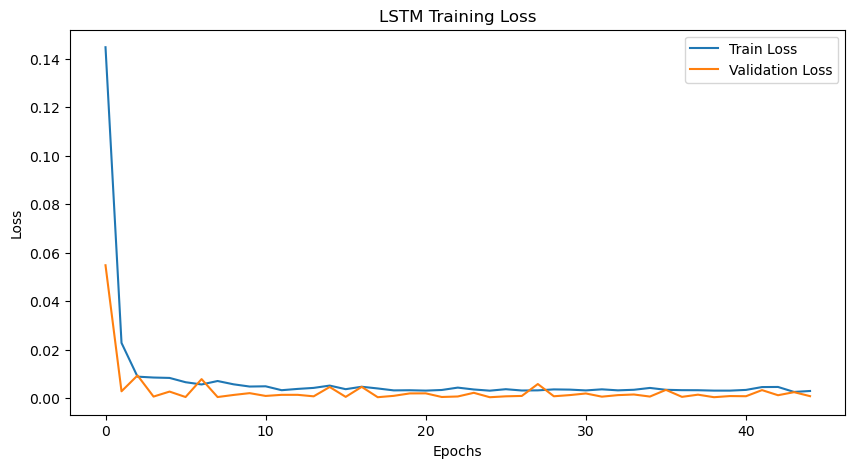

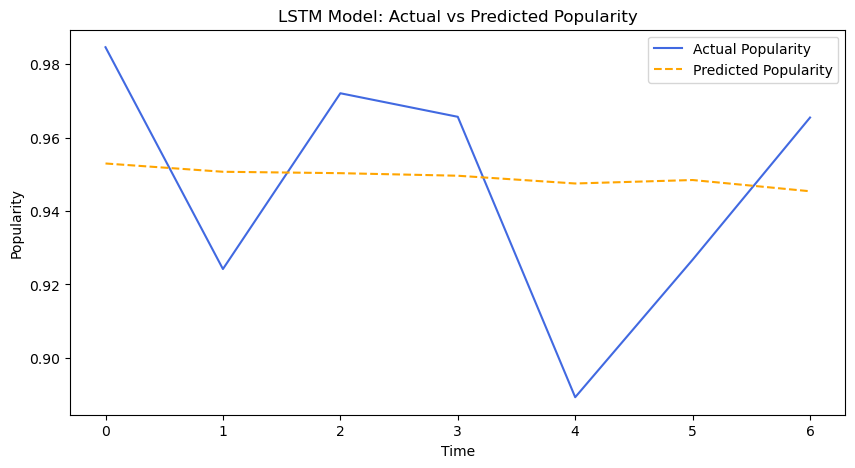

In [ ]:
lstm_model = train_optimized_lstm_2(restaurants_df)
